# Scaling behavior

In [3]:
%matplotlib inline

import subprocess
import json
import os
import pandas
import numpy

## Tools
For generating scaling scenarios and running it through guv

In [8]:
def normalize_scenario(flat):
    # Pop out messages
    messages = flat['messages']
    # Everything else assumed to be config
    roleconfig = flat.copy()
    del roleconfig['messages']
    config = { 'test': flat }
    s = {
        'role': 'test',
        'config': config,
        'messages': messages,
    }
    return s

def calculate_scaling(scenarios, timeout=10):
    normalized = [normalize_scenario(s) for s in scenarios]
    serialized = json.dumps(normalized)
        
    args = ['../node_modules/.bin/coffee', './scalescenarios.coffee']
    try:
        stdout = subprocess.check_output(args, input=serialized,
                                         encoding='utf-8', timeout=timeout, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        raise Exception(e.stdout)

    try:
        results = json.loads(stdout)
    except Exception as e:
        print('Could not parse stdout', std)
    
    return results

def merge(a, b):
    d = a.copy()
    d.update(b)
    return d


# Workers versus queue length
For different processing times (fixed deadline).
Should generally be linear, as guv has a proportional scaling algorithm

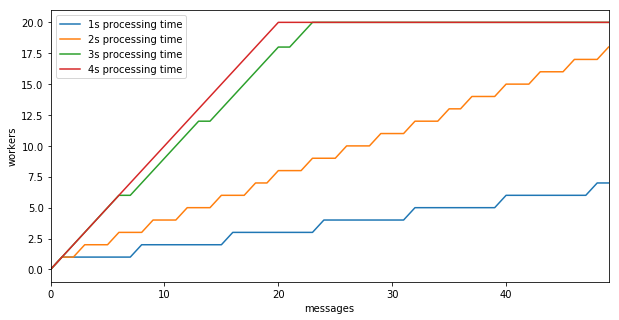

In [10]:
base = dict(minimum=0, maximum=20, processing=2, deadline=10, messages=-1)
messages = range(0, 50)

def versus_messages(processing):
    scenarios = [ merge(base, { 'messages': m, 'processing': processing }) for m in messages ] 
    res = calculate_scaling(scenarios)
    return res

df = pandas.DataFrame({
    'messages': messages,
    '1s processing time': versus_messages(processing=1),
    '2s processing time': versus_messages(processing=2),
    '3s processing time': versus_messages(processing=3),
    '4s processing time': versus_messages(processing=4),
})
ax = df.plot(x='messages', figsize=(10, 5))
ax.set_ylabel("workers")
ax

# Workers versus closeness to deadline
By moving processing time towards deadline. 
Could alternatively have moved deadline down towards a fixed processing time.

In [ ]:
processing_times = numpy.arange(0.1, 10.0, 0.2)

def versus_processing(messages):
    base = dict(minimum=0, maximum=20, processing=2, deadline=10, concurrency=1, messages=-1)
    scenarios = [ merge(base, { 'messages': messages, 'processing': p }) for p in processing_times ]
    res = calculate_scaling(scenarios)
    return res

df = pandas.DataFrame({
    'processing': processing_times,
    '0 message': versus_processing(messages=0),
    '1 message': versus_processing(messages=1),
    '4 message': versus_processing(messages=4),
    '8 message': versus_processing(messages=8),
    '32 message': versus_processing(messages=32),
})
ax = df.plot(x='processing', figsize=(10, 5))
ax.set_ylabel("workers")
ax